## 1. 流匹配 Flow Matching

通过直接匹配一个源分布到数据分布的连续变换路径的学习方法。

[Flow Matching 论文](https://arxiv.org/pdf/2210.02747)

In [2]:
from IPython.display import Image, display
url = 'https://github.com/facebookresearch/flow_matching/blob/main/assets/teaser.png?raw=true'
display(Image(url=url, width=800))

## 2. 数学表达

在这份指南中，提供了详尽的解答。[Flow Matching Guide and Code](https://arxiv.org/pdf/2412.06264)

Flow Matching 目标是通过连续时间动态系统（常微分方程，ODE）建模数据分布演化，直接学习一个向量场（vector field），使得从噪声分布（如高斯分布）出发沿该向量场积分得到的流（flow）能够匹配目标数据分布。其核心数学工具是最优传输理论（OT）和概率路径的连续归一化流（CNF）

$t=0$ 时刻的状态 $x_0$ 服从初始分布 $p_0$

$t=1$ 时刻的状态 $x_1$ 服从数据分布 $p_1$

中间任意 $t$ 时刻的状态，$x_t$ 满足某个光滑函数 $\phi_t(x)$，最简单的如线性插值， $\phi_t(x)=x_t = (1-t)x_0 + tx_1$

则向量场生成的轨迹可以由ODE描述， $$\frac{d}{dt}\phi_t(x)=u_t(\phi_t(x)),\phi_0(x)=x_0\sim p_0$$

在整个演化过程中，概率密度 $p_t(x)$ 必须满足连续性方程（质量守恒），这是个PDE方程：$$\frac{d}{dt}p_t(x)+\nabla\cdot(p_t(x)u_t(x))=0$$

在线性插值中，有 $\frac{d}{dt}x_t = x_1-x_0$

也就是模型所需要学习的目标。模型的输入是 $x_t$ 和 $t$，其中，$t\sim U(0,1)$

即学习一个参数化的向量场 $u_t(x;\theta)\rightarrow u_t(x)$

有损失函数： $$\mathcal{L}_{FM}(\theta)=\mathbb{E}_{t\sim U(0,1),x\sim p_t(x)}||u_t(x;\theta)-u_t(x)||^2$$

但在一般情况下，由于 $u_t(x)$ 未知，但有 $z\sim p_1$ 是目标分布中的样本，引入条件概率路径 $$p(x|z) \ s.t.\  p_0(x|z)=p_0(x), p_1(x|z)=\delta(x-z)$$

损失函数为：$$\mathcal{L}_{CFM}(\theta)=\mathbb{E}_{t\sim U(0,1),z\sim p_1,x\sim p_t(x|z)}||u_t(x;\theta)-u_t(x|z)||^2$$

---

**要点1：概率路径是提前设计的**

线性插值当然是最简单，也可以有非线性路径，如另外一个神经网络。

在黎曼流形上，则可引入测地线，作为最短路径。

此外，还有一个思路是引入与时间相关的方差调度，控制路径扩散。导则指引P30。

**要点2：条件信息引注入**

如分类标签、文本描述、多模态等条件融合，编入条件路径。

**要点3：向量场设计**

也就是模型设计。（1）时间嵌入；（2）条件信息嵌入；（3）目标向量场推导；（4）损失函数。

其中，目标向量场取决于路径设计，在线性插值中，目标向量场为：$$u_t(x|z)=\frac{z-x_0}{1-t}$$

对应的损失函数是：$$\mathcal{L}_{CFM}(\theta)=\mathbb{E}_{t,z,x_0} \left\| u_t(\phi_t(x_0);\theta)-\frac{z-x_0}{1-t}\right\| ^2$$

## 3. 简单实现

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torchvision import transforms
from torch.amp import autocast, GradScaler
from torchinfo import summary
import math
import os
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, Subset
import torchvision.utils as vutils
import tqdm

In [2]:
# 超参数
image_size = 256
downscale = 4
batch_size = 32
in_channels = 3
out_channels = 3
epochs = 40
learning_rate = 1e-4
latent_dim = 32
save_path = 'model_pkl/flow_matching_latent_01.pth'
data_path = 'data/celeba_hq_256/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(tensor.device)
    return tensor * std + mean

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
# CelebA-HQ Super-Resolution Dataset
class CelebASuperRes(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, size=256, downscale=4):
        self.root = root
        self.transform = transform
        self.size = size
        self.downscale = downscale
        self.images = [f for f in os.listdir(root) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.root, self.images[idx])).convert('RGB')
        hr = transforms.Resize((self.size, self.size))(img)
        lr = transforms.Resize((self.size // self.downscale, self.size // self.downscale))(hr)
        lr = transforms.Resize((self.size, self.size), interpolation=Image.BICUBIC)(lr)
        if self.transform:
            hr = self.transform(hr)
            lr = self.transform(lr)
        return hr, lr

In [5]:
dataset = CelebASuperRes(data_path, transform=transform, size=image_size, downscale=downscale)
subset_dataset = Subset(dataset, range(1600))
dataloader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
unloader = transforms.ToPILImage()

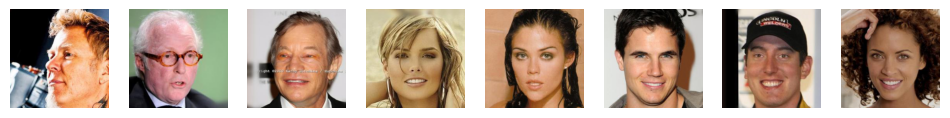

In [6]:
images, _ = next(iter(dataloader))  # images: [B, 3, 256, 256]
images = denormalize(images[:8], mean, std)
# 去通道维度并绘图
fig, axes = plt.subplots(1, 8, figsize=(12, 2))
for i in range(8):
    axes[i].imshow(images[i].permute(1,2,0).cpu().numpy())
    axes[i].axis("off")
plt.show()

In [7]:
class VAE(nn.Module):
    def __init__(self, in_channels=in_channels, latent_dim=latent_dim):  
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, latent_dim, kernel_size=3, stride=1, padding=1) 
        )

        self.conv_mu = nn.Conv2d(latent_dim, latent_dim, 1)
        self.conv_logvar = nn.Conv2d(latent_dim, latent_dim, 1)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, in_channels, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )  
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        enc = self.encoder(x)
        mu = self.conv_mu(enc)
        logvar = self.conv_logvar(enc)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar

In [8]:
model_vae=VAE().to(device)
model_vae.load_state_dict(torch.load('model_pkl/model_vae_02.pth'))
model_vae.eval()

C:\Users\sheng\AppData\Local\Temp\ipykernel_39084\1852388198.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_vae.load_state_dict(torch.load('model_pkl/model_vae_02

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(512, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (conv_mu): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv_logvar): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (decoder): Sequential(
    (

In [9]:
def plot_images(original_images, reconstructed_images, n_row=2, n_col=2):
    original_images = original_images.detach().cpu().numpy()
    reconstructed_images = reconstructed_images.detach().cpu().numpy()
    
    fig, axes = plt.subplots(n_row, n_col * 2, figsize=(8, 4))
    
    for i in range(n_row):
        for j in range(n_col):
            idx = i * n_col + j
            if idx >= original_images.shape[0]:
                continue
            axes[i, j * 2].imshow(np.transpose(original_images[idx], (1, 2, 0)))
            axes[i, j * 2].set_title("Original")
            axes[i, j * 2].axis('off')

            axes[i, j * 2 + 1].imshow(np.transpose(reconstructed_images[idx], (1, 2, 0)))
            axes[i, j * 2 + 1].set_title("Reconstructed")
            axes[i, j * 2 + 1].axis('off')
    
    plt.tight_layout()
    plt.show()

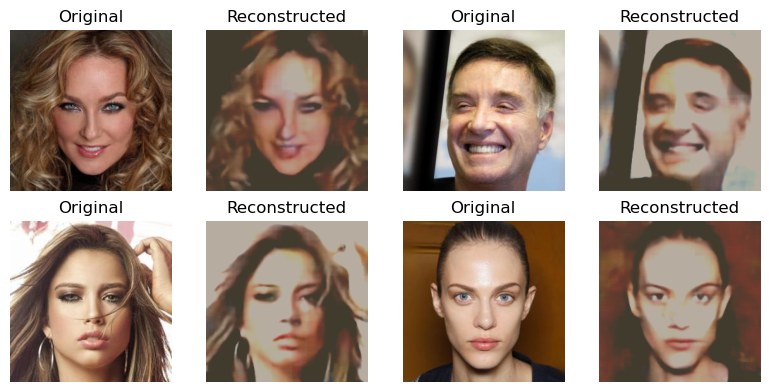

In [10]:
# 获取并展示重建的图像
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(tensor.device)
    return tensor * std + mean

model_vae.eval()
with torch.no_grad():
    sample_data, _ = next(iter(dataloader))
    sample_data = sample_data.to(device)
    original_images = sample_data
    original_images = denormalize(original_images, mean=mean, std=std)
    reconstructed_images = model_vae(sample_data)[0]
    reconstructed_images = denormalize(reconstructed_images, mean=mean, std=std)
    plot_images(original_images, reconstructed_images)

In [11]:
# Time embedding
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear1 = nn.Linear(dim, dim * 4)
        self.linear2 = nn.Linear(dim * 4, dim)
        self.act = nn.SiLU()

    def forward(self, t):
        half_dim = self.linear1.in_features // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return self.linear2(self.act(self.linear1(emb)))

In [12]:
# Residual block with time embedding
class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU()
        )
        self.time_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_ch)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU()
        )
        self.residual = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb):
        h = self.block1(x)
        h = h + self.time_mlp(t_emb).squeeze(1)[:,:,None,None]
        h = self.block2(h)
        return h + self.residual(x)

In [13]:
# Self-Attention block (for 2D images)
class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm = nn.GroupNorm(8, channels)
        self.q = nn.Conv1d(channels, channels, 1)
        self.k = nn.Conv1d(channels, channels, 1)
        self.v = nn.Conv1d(channels, channels, 1)
        self.proj = nn.Conv1d(channels, channels, 1)

    def forward(self, x):
        B, C, H, W = x.shape
        x_ = self.norm(x).view(B, C, H * W)  # [B, C, HW]
        q, k, v = self.q(x_), self.k(x_), self.v(x_)

        attn = torch.softmax(q.transpose(1, 2) @ k / math.sqrt(C), dim=-1)
        out = v @ attn.transpose(1, 2)  # [B, C, HW]
        out = self.proj(out).view(B, C, H, W)
        return out + x

In [14]:
# UNet with Conv down/up and center attention
class UNet(nn.Module):
    def __init__(self, time_emb_dim=128):
        super().__init__()
        self.time_embedding = TimeEmbedding(time_emb_dim)

        self.enc1 = ResBlock(32, 256, time_emb_dim)
        self.down1 = nn.Conv2d(256, 512, 4, 2, 1)  # downsample
        self.enc2 = ResBlock(512, 512, time_emb_dim)

        self.mid = nn.Sequential(
            ResBlock(512, 512, time_emb_dim),
            AttentionBlock(512),
            ResBlock(512, 512, time_emb_dim)
        )

        self.up1 = nn.ConvTranspose2d(512, 256, 4, 2, 1)  # upsample
        self.dec1 = ResBlock(256, 256, time_emb_dim)
        self.out = nn.Conv2d(256, 32, 1)

    def forward(self, x, t):
        t_emb = self.time_embedding(t)

        x1 = self.enc1(x, t_emb)
        x2 = self.enc2(self.down1(x1), t_emb)
        
        # 修改点：传递 t_emb 给 mid
        x_mid = self.mid[0](x2, t_emb)  # ResBlock
        x_mid = self.mid[1](x_mid)      # AttentionBlock
        x_mid = self.mid[2](x_mid, t_emb)  # ResBlock

        x_up = self.dec1(self.up1(x_mid), t_emb)
        return self.out(x_up)

In [15]:
learning_rate = 1e-4
epochs = 40

In [16]:
# 初始化模型，并转到对应设备
model = UNet().to(device)

# 定义优化器与损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [17]:
summary(model, input_size=[(32,32,32,32),(1,)])

Layer (type:depth-idx)                   Output Shape              Param #
UNet                                     [32, 32, 32, 32]          --
├─TimeEmbedding: 1-1                     [1, 128]                  --
│    └─Linear: 2-1                       [1, 512]                  66,048
│    └─SiLU: 2-2                         [1, 512]                  --
│    └─Linear: 2-3                       [1, 128]                  65,664
├─ResBlock: 1-2                          [32, 256, 32, 32]         --
│    └─Sequential: 2-4                   [32, 256, 32, 32]         --
│    │    └─Conv2d: 3-1                  [32, 256, 32, 32]         73,984
│    │    └─GroupNorm: 3-2               [32, 256, 32, 32]         512
│    │    └─SiLU: 3-3                    [32, 256, 32, 32]         --
│    └─Sequential: 2-5                   [1, 256]                  --
│    │    └─SiLU: 3-4                    [1, 128]                  --
│    │    └─Linear: 3-5                  [1, 256]                  33,02

In [18]:
# 可视化保存路径
def save_samples(samples, step, path="./images/FM_geo/"):
    os.makedirs(path, exist_ok=True)
    save_image(samples, os.path.join(path, f"{step:04d}.png"), nrow=8, normalize=True)

球面测地线插值路径：
$$\phi(t)=\frac{\sin((1-t)\theta))}{\sin\theta}\hat z+\frac{\sin(t\theta)}{\sin\theta}\hat x , \  t\in[0,1]$$

求导：
$$\frac{d}{dt}\phi(t)=\frac{\theta\cos(t\theta)}{\sin\theta}(\hat x - \cos\theta\hat z) $$

$clamp(-1 + eps, 1 - eps)$ 防止 $\arccos$ 输入超出定义域

添加 $eps$ 避免 $\sin\theta$ 为零导致数值错误

In [19]:
# === Geodesic Helpers using Spherical Interpolation ===
def geodesic_curve(z, x, t):
    z_flat = z.view(z.size(0), -1)
    x_flat = x.view(x.size(0), -1)
    z_norm = F.normalize(z_flat, dim=-1)
    x_norm = F.normalize(x_flat, dim=-1)
    dot = (z_norm * x_norm).sum(dim=-1, keepdim=True).clamp(-1, 1)
    theta = torch.acos(dot)
    sin_theta = torch.sin(theta)
    t = t.view(-1, 1)
    coeff1 = torch.sin((1 - t) * theta) / sin_theta
    coeff2 = torch.sin(t * theta) / sin_theta
    interp = coeff1 * z_flat + coeff2 * x_flat
    return interp.view_as(z)

def geodesic_velocity(z, x, t):
    eps = 1e-7
    z_flat = z.view(z.size(0), -1)
    x_flat = x.view(x.size(0), -1)
    z_norm = F.normalize(z_flat, dim=-1)
    x_norm = F.normalize(x_flat, dim=-1)
    dot = (z_norm * x_norm).sum(dim=-1, keepdim=True).clamp(-1 + eps, 1 - eps)
    theta = torch.acos(dot)
    sin_theta = torch.sin(theta)
    t = t.view(-1, 1)
    coeff1 = torch.cos(t * theta) * theta * (x_flat - dot * z_flat) / (sin_theta + eps)
    return coeff1.view_as(z)

In [21]:
@torch.no_grad()
def visualize_prediction(model, x_img, model_vae, steps=8):
    model.eval()
    x_img = x_img.to(device)
    z = torch.randn_like(x_img)
    x = model_vae.encoder(x_img)
    z = model_vae.encoder(z)
    images = []
    for i in range(steps+1):
        t_val = i / steps
        t = torch.full((x.size(0), 1), t_val, device=device)
        x_t = geodesic_curve(z, x, t)
        v = model(x_t, t)
        x_hat = x_t + v
        recon = model_vae.decoder(x_hat)
        recon = denormalize(recon, mean, std)
        images.append(recon)
    grid = vutils.make_grid(torch.cat(images), nrow=steps+1)
    plt.figure(figsize=(20, 4))
    plt.axis("off")
    plt.title("Prediction Trajectory")
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.show()

In [22]:
@torch.no_grad()
def visualize_from_noise(model, model_vae, n_samples=8):
    model.eval()
    z = torch.randn(n_samples, 32, 32, 32).to(device)
    x = torch.zeros_like(z)
    steps = 8
    for i in range(steps):
        t_val = (i + 1) / steps
        t = torch.full((n_samples, 1), t_val, device=device)
        x_t = geodesic_curve(z, x, t)
        v = model(x_t, t)
        x = x_t + v
    recon = model_vae.decoder(x)
    recon = denormalize(recon, mean, std)
    grid = vutils.make_grid(recon, nrow=n_samples)
    plt.figure(figsize=(20, 4))
    plt.axis("off")
    plt.title("Generated Samples from Noise")
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.show()

In [23]:
@torch.no_grad() # 因为球面插值，和直接encoder-decoder结果不同
def visualize_interpolation(model_vae, x_img, steps=8):
    x_img = x_img.to(device)
    z_img = torch.randn_like(x_img)
    x = model_vae.encoder(x_img)
    z = model_vae.encoder(z_img)
    images = []
    for i in range(steps+1):
        t_val = i / steps
        t = torch.full((x.size(0), 1), t_val, device=device)
        x_t = geodesic_curve(z, x, t)
        recon = model_vae.decoder(x_t)
        recon = denormalize(recon, mean, std)
        images.append(recon)
    grid = vutils.make_grid(torch.cat(images), nrow=steps+1)
    plt.figure(figsize=(20, 4))
    plt.axis("off")
    plt.title("Interpolation from Noise to Image")
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.show()

Epoch 0: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.76it/s, loss=0.305]


[Epoch 0] Loss: 0.2637


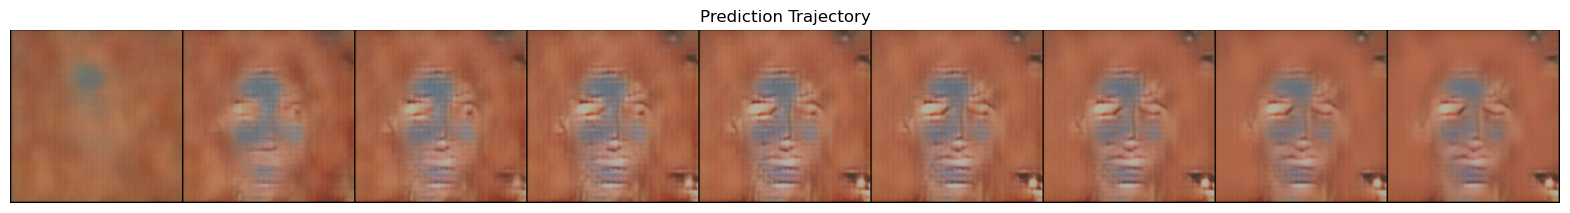

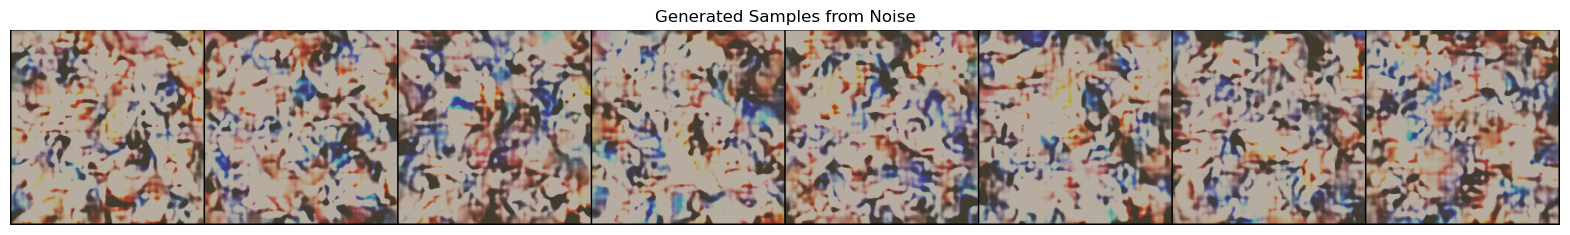

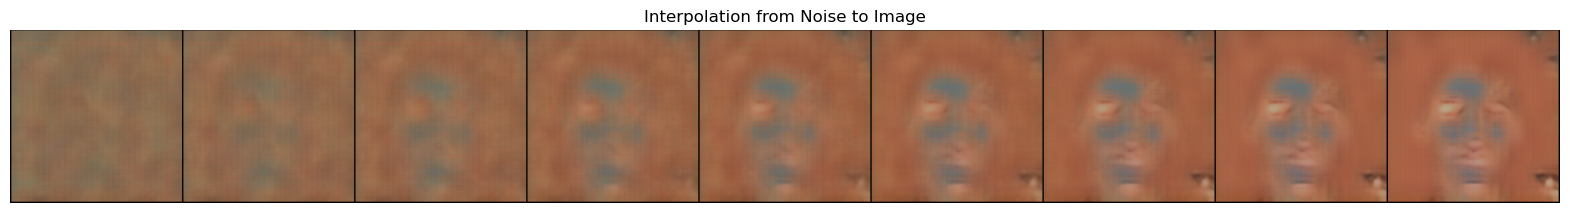

Epoch 1: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.78it/s, loss=0.264]


[Epoch 1] Loss: 0.2685


Epoch 2: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.77it/s, loss=0.272]


[Epoch 2] Loss: 0.2813


Epoch 3: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:28<00:00,  1.75it/s, loss=0.436]


[Epoch 3] Loss: 0.2881


Epoch 4: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:29<00:00,  1.68it/s, loss=0.216]


[Epoch 4] Loss: 0.2791


Epoch 5: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.66it/s, loss=0.244]


[Epoch 5] Loss: 0.2841


Epoch 6: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.62it/s, loss=0.349]


[Epoch 6] Loss: 0.2712


Epoch 7: 100%|██████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s, loss=0.27]


[Epoch 7] Loss: 0.2607


Epoch 8: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.58it/s, loss=0.201]


[Epoch 8] Loss: 0.2799


Epoch 9: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.59it/s, loss=0.247]


[Epoch 9] Loss: 0.2848


Epoch 10: 100%|████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.57it/s, loss=0.493]


[Epoch 10] Loss: 0.2753


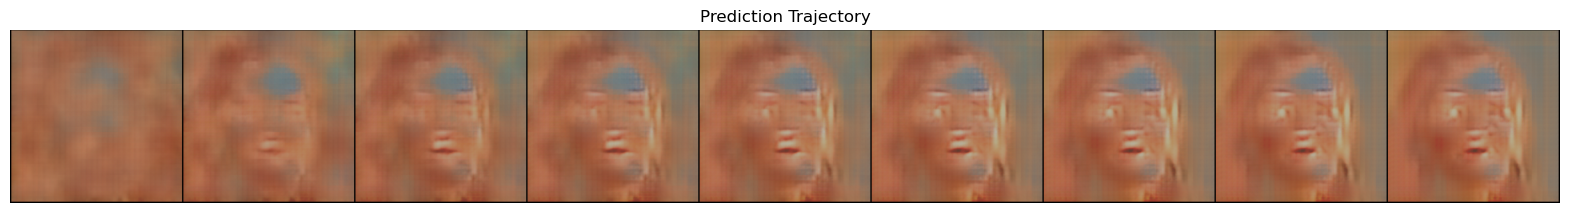

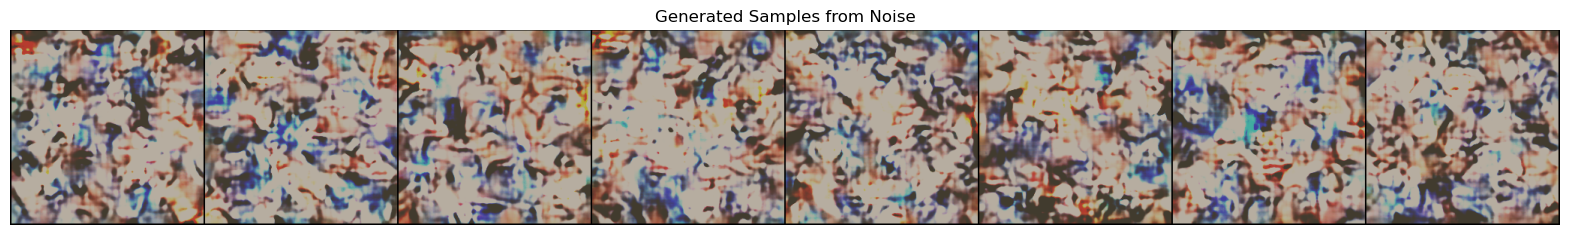

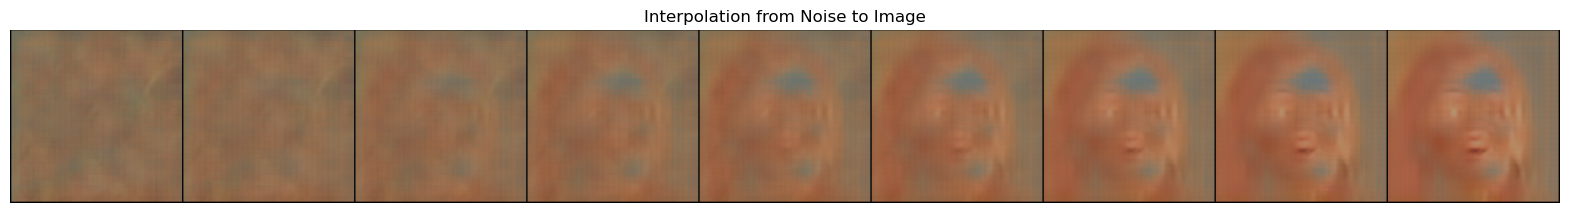

Epoch 11: 100%|████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.57it/s, loss=0.241]


[Epoch 11] Loss: 0.2884


Epoch 12: 100%|████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.57it/s, loss=0.327]


[Epoch 12] Loss: 0.2664


Epoch 13: 100%|████████████████████████████████████████████████████████████| 50/50 [00:31<00:00,  1.57it/s, loss=0.212]


[Epoch 13] Loss: 0.2781


Epoch 14: 100%|████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.56it/s, loss=0.299]


[Epoch 14] Loss: 0.2819


Epoch 15: 100%|██████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s, loss=0.2]


[Epoch 15] Loss: 0.2786


Epoch 16: 100%|████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.56it/s, loss=0.283]


[Epoch 16] Loss: 0.3016


Epoch 17: 100%|████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.56it/s, loss=0.411]


[Epoch 17] Loss: 0.2547


Epoch 18: 100%|████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s, loss=0.241]


[Epoch 18] Loss: 0.2575


Epoch 19: 100%|████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s, loss=0.248]


[Epoch 19] Loss: 0.2788


Epoch 20: 100%|████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.56it/s, loss=0.296]


[Epoch 20] Loss: 0.2706


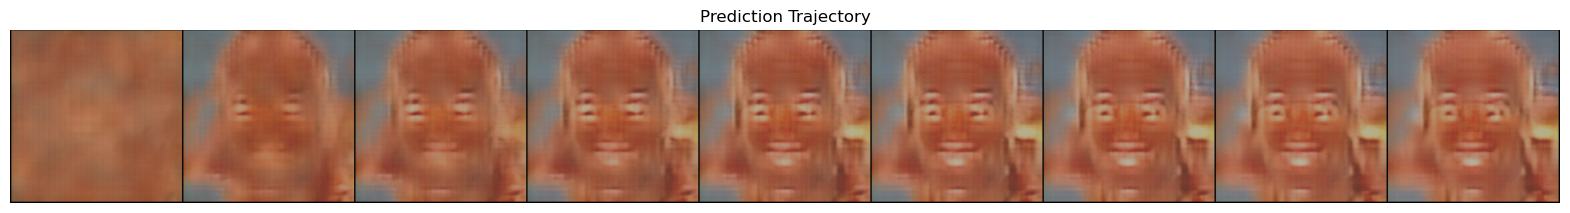

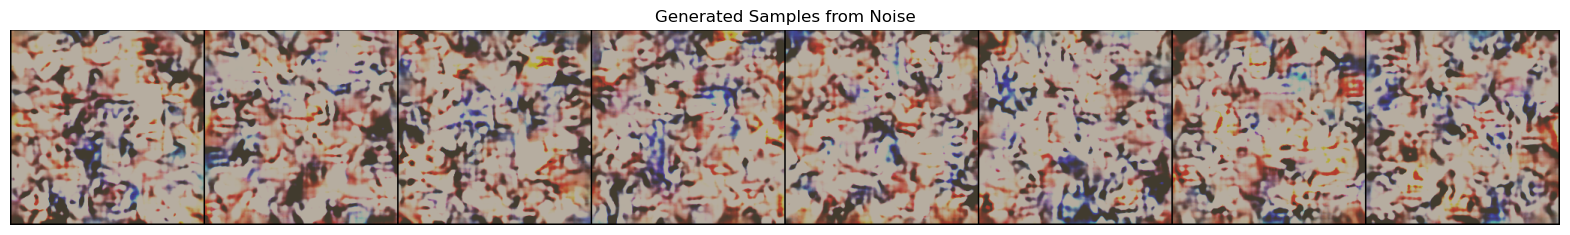

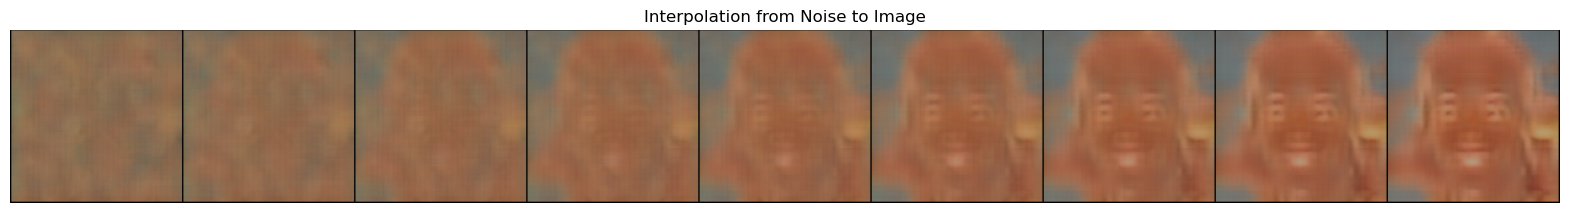

Epoch 21: 100%|████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.56it/s, loss=0.266]


[Epoch 21] Loss: 0.2934


Epoch 22: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s, loss=0.36]


[Epoch 22] Loss: 0.3024


Epoch 23: 100%|████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s, loss=0.308]


[Epoch 23] Loss: 0.2881


Epoch 24: 100%|████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.56it/s, loss=0.249]


[Epoch 24] Loss: 0.2705


Epoch 25: 100%|████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.54it/s, loss=0.264]


[Epoch 25] Loss: 0.2598


Epoch 26: 100%|██████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s, loss=0.3]


[Epoch 26] Loss: 0.2811


Epoch 27: 100%|████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s, loss=0.192]


[Epoch 27] Loss: 0.2644


Epoch 28: 100%|████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s, loss=0.326]


[Epoch 28] Loss: 0.2899


Epoch 29: 100%|████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.54it/s, loss=0.156]


[Epoch 29] Loss: 0.2712


Epoch 30: 100%|████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.54it/s, loss=0.277]


[Epoch 30] Loss: 0.2613


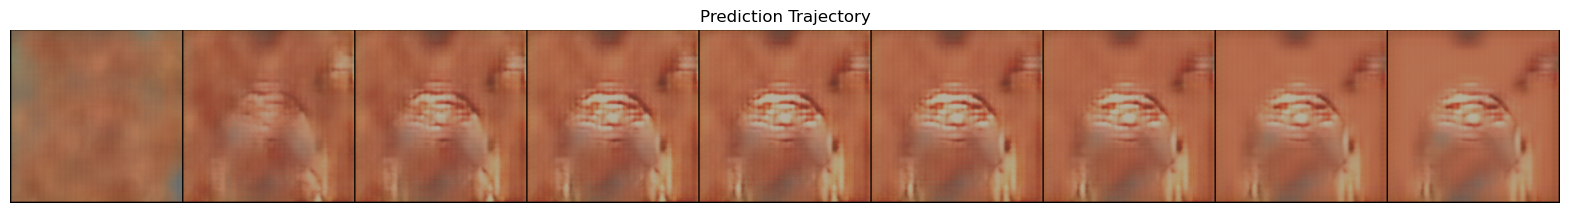

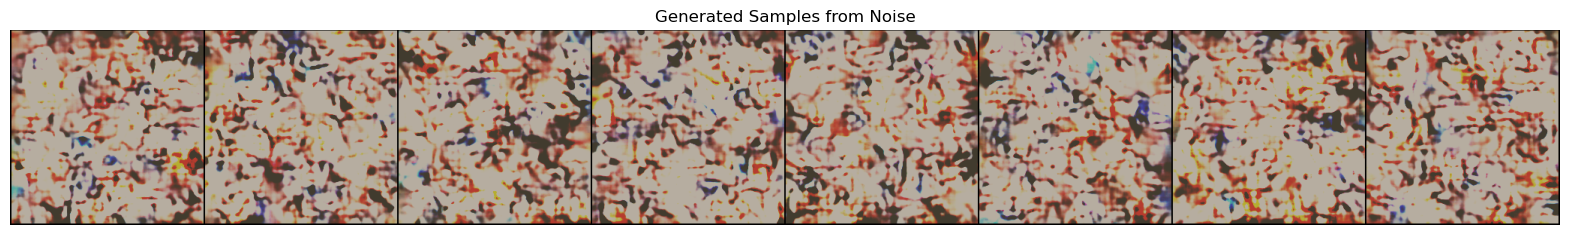

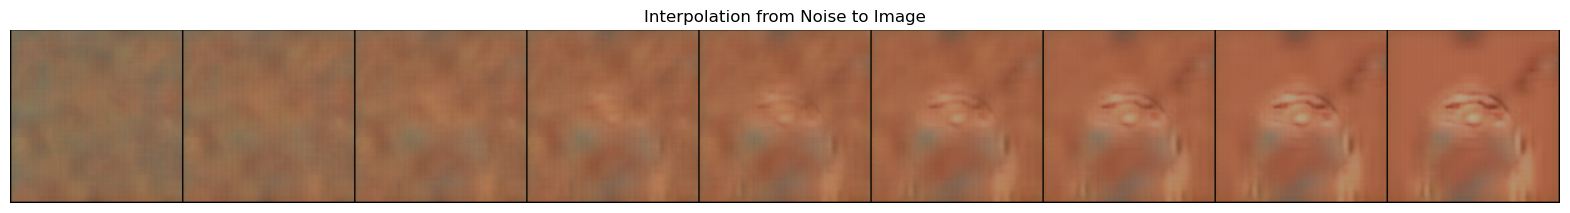

Epoch 31: 100%|████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.56it/s, loss=0.323]


[Epoch 31] Loss: 0.2610


Epoch 32: 100%|█████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s, loss=0.25]


[Epoch 32] Loss: 0.2627


Epoch 33: 100%|████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s, loss=0.362]


[Epoch 33] Loss: 0.2562


Epoch 34: 100%|████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.54it/s, loss=0.229]


[Epoch 34] Loss: 0.2704


Epoch 35: 100%|████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.52it/s, loss=0.234]


[Epoch 35] Loss: 0.2852


Epoch 36: 100%|████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.55it/s, loss=0.367]


[Epoch 36] Loss: 0.2857


Epoch 37: 100%|████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.54it/s, loss=0.259]


[Epoch 37] Loss: 0.2778


Epoch 38: 100%|████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.54it/s, loss=0.223]


[Epoch 38] Loss: 0.2449


Epoch 39: 100%|████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.54it/s, loss=0.396]

[Epoch 39] Loss: 0.2936


In [25]:
for epoch in range(epochs):
    model.train()
    pbar = tqdm.tqdm(dataloader, desc=f"Epoch {epoch}")
    total_loss = 0
    for batch_idx, (x, _) in enumerate(pbar):
        x0_img = x.to(device)
        z_img = torch.randn_like(x0_img)

        x0 = model_vae.encoder(x0_img)
        z = model_vae.encoder(z_img)

        t = torch.rand(x0.size(0), 1).to(device)

        x_t = geodesic_curve(z, x0, t)
        target_v = geodesic_velocity(z, x0, t)

        pred_v = model(x_t, t)
        
        loss = criterion(pred_v, target_v)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()        
        pbar.set_postfix(loss=loss.item())

        # 打印训练过程中的信息

    scheduler.step()  # 更新学习率
    avg_loss = total_loss / len(dataloader)
    print(f"[Epoch {epoch}] Loss: {avg_loss:.4f}")

    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            x0_vis = next(iter(dataloader))[0][:8].to(device)
            visualize_prediction(model, x0_vis[0:1], model_vae)
            visualize_from_noise(model, model_vae)
            visualize_interpolation(model_vae, x0_vis[0:1], steps=8)

torch.Size([1, 3, 256, 256])


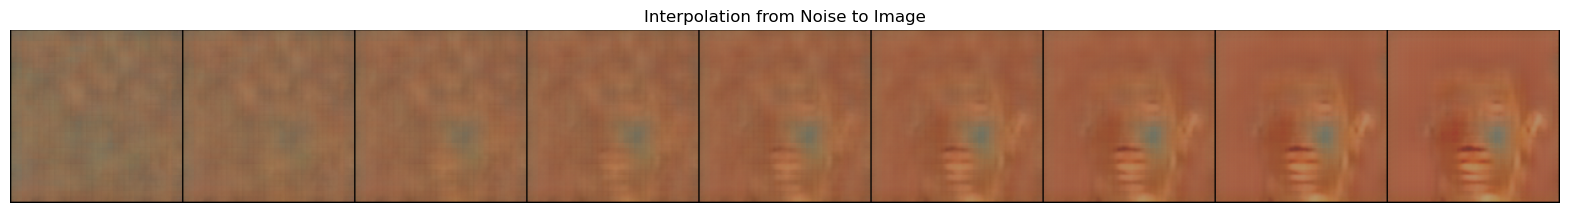

In [85]:
sample = next(iter(dataloader))
x_sample = sample[0][0:1]  # 取一个样本
print(x_sample.shape)
z_sample = torch.randn_like(x_sample)

# 插值过程可视化
visualize_interpolation(model_vae=model_vae, x_img=x_sample, steps=8)